<a href="https://colab.research.google.com/github/PriyanshiThakkar/Consumer-Complaint-Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1 : Data Processing

In [11]:
from google.colab import files
uploaded = files.upload()

Saving complaints-2025-07-28_23_11.csv to complaints-2025-07-28_23_11 (1).csv


In [12]:
import pandas as pd

df = pd.read_csv('complaints-2025-07-28_23_11.csv')
print(df.shape)    # Check rows and columns
print(df.columns)  # See available columns

(21451, 18)
Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')


In [13]:
columns_to_keep = [
    'Date received',
    'Product',
    'Consumer complaint narrative',
    'Company',
    'Company response to consumer',
    'Timely response?'
]
df = df[columns_to_keep]


In [14]:
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].fillna('')

In [15]:
df['Date received'] = pd.to_datetime(df['Date received'], errors='coerce')
df = df.dropna(subset=['Date received'])

/tmp/ipython-input-15-3888684760.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date received'] = pd.to_datetime(df['Date received'], errors='coerce')


In [16]:
df['Year'] = df['Date received'].dt.year
df['Month'] = df['Date received'].dt.month

In [17]:
df = df.drop_duplicates()

In [18]:
print("Dataset Shape:", df.shape)
print("Missing Values:\n", df.isnull().sum())
print(df.head())

Dataset Shape: (18524, 8)
Missing Values:
 Date received                   0
Product                         0
Consumer complaint narrative    0
Company                         0
Company response to consumer    0
Timely response?                0
Year                            0
Month                           0
dtype: int64
  Date received   Product                       Consumer complaint narrative  \
0    2024-06-13  Mortgage  I got an XXXX  month deferment of my mortgage ...   
1    2024-04-12  Mortgage  I am attaching copies of the following so that...   
2    2024-10-11  Mortgage  I am writing to formally dispute the unauthori...   
3    2024-05-16  Mortgage  My mortgage loan was recently originated. The ...   
4    2024-03-14  Mortgage  I signed up for a 15-year mortgage back in XXX...   

                                  Company Company response to consumer  \
0   BANK OF AMERICA, NATIONAL ASSOCIATION      Closed with explanation   
1                   WELLS FARGO & COMPANY  

Step 2 : Text Cleaning with NLTK

In [23]:
!pip install nltk
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# Removed the incorrect download line

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove special characters & numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize using regex
    tokens = re.findall(r'\b\w+\b', text)
    # Remove stopwords & lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [25]:
df['Cleaned_Complaint'] = df['Consumer complaint narrative'].apply(clean_text)
print(df[['Consumer complaint narrative','Cleaned_Complaint']].head())


                        Consumer complaint narrative  \
0  I got an XXXX  month deferment of my mortgage ...   
1  I am attaching copies of the following so that...   
2  I am writing to formally dispute the unauthori...   
3  My mortgage loan was recently originated. The ...   
4  I signed up for a 15-year mortgage back in XXX...   

                                   Cleaned_Complaint  
0  got xxxx month deferment mortgage covid pandem...  
1  attaching copy following view case able see ex...  
2  writing formally dispute unauthorized use onet...  
3  mortgage loan recently originated servicing so...  
4  signed year mortgage back xxxx maturity date l...  


Step 3 : Sentiment Analysis using VADER (rule-based) BERT (ML-based)

In [26]:
!pip install nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [27]:
# Initialize analyzer
vader = SentimentIntensityAnalyzer()

# Apply sentiment scoring
df['VADER_Sentiment'] = df['Cleaned_Complaint'].apply(lambda x: vader.polarity_scores(x)['compound'])

# Categorize sentiment
def categorize_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['VADER_Label'] = df['VADER_Sentiment'].apply(categorize_sentiment)


In [28]:
print(df[['Cleaned_Complaint', 'VADER_Sentiment', 'VADER_Label']].head())
print(df['VADER_Label'].value_counts())


                                   Cleaned_Complaint  VADER_Sentiment  \
0  got xxxx month deferment mortgage covid pandem...           0.7096   
1  attaching copy following view case able see ex...           0.9989   
2  writing formally dispute unauthorized use onet...           0.8894   
3  mortgage loan recently originated servicing so...          -0.8020   
4  signed year mortgage back xxxx maturity date l...           0.8126   

  VADER_Label  
0    Positive  
1    Positive  
2    Positive  
3    Negative  
4    Positive  
VADER_Label
Neutral     6836
Positive    6346
Negative    5342
Name: count, dtype: int64


In [29]:
!pip install transformers torch
from transformers import pipeline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 800.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [30]:
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


In [33]:
# Apply BERT to a sample (first 100 rows for speed)
df_sample = df.head(100).copy() # Create a copy to avoid SettingWithCopyWarning
max_length = 512 # Define the maximum sequence length

# Truncate the text using the pipeline's built-in truncation
results = sentiment_pipeline(df_sample['Cleaned_Complaint'].tolist(), max_length=max_length, truncation=True)

# Extract sentiment and score from the results
df_sample['BERT_Sentiment'] = [result['label'] for result in results]
df_sample['BERT_Score'] = [result['score'] for result in results]

print(df_sample[['Cleaned_Complaint','BERT_Sentiment','BERT_Score']].head())

                                   Cleaned_Complaint BERT_Sentiment  \
0  got xxxx month deferment mortgage covid pandem...       NEGATIVE   
1  attaching copy following view case able see ex...       NEGATIVE   
2  writing formally dispute unauthorized use onet...       NEGATIVE   
3  mortgage loan recently originated servicing so...       NEGATIVE   
4  signed year mortgage back xxxx maturity date l...       NEGATIVE   

   BERT_Score  
0    0.997089  
1    0.981317  
2    0.990340  
3    0.993516  
4    0.994451  


Step 4 : Visualize using Matplotlib and Seaborn

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

/tmp/ipython-input-36-2289138204.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='VADER_Label', order=['Positive','Neutral','Negative'], palette='viridis')


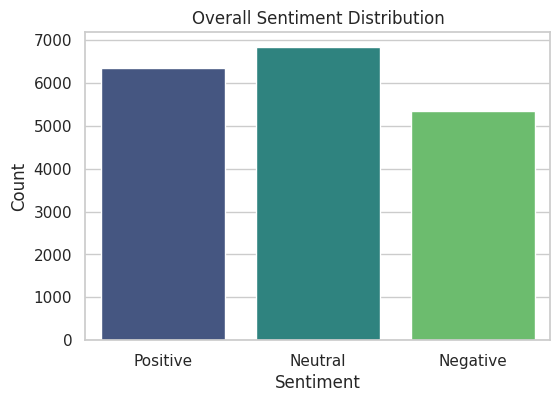

In [36]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='VADER_Label', order=['Positive','Neutral','Negative'], palette='viridis')
plt.title('Overall Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


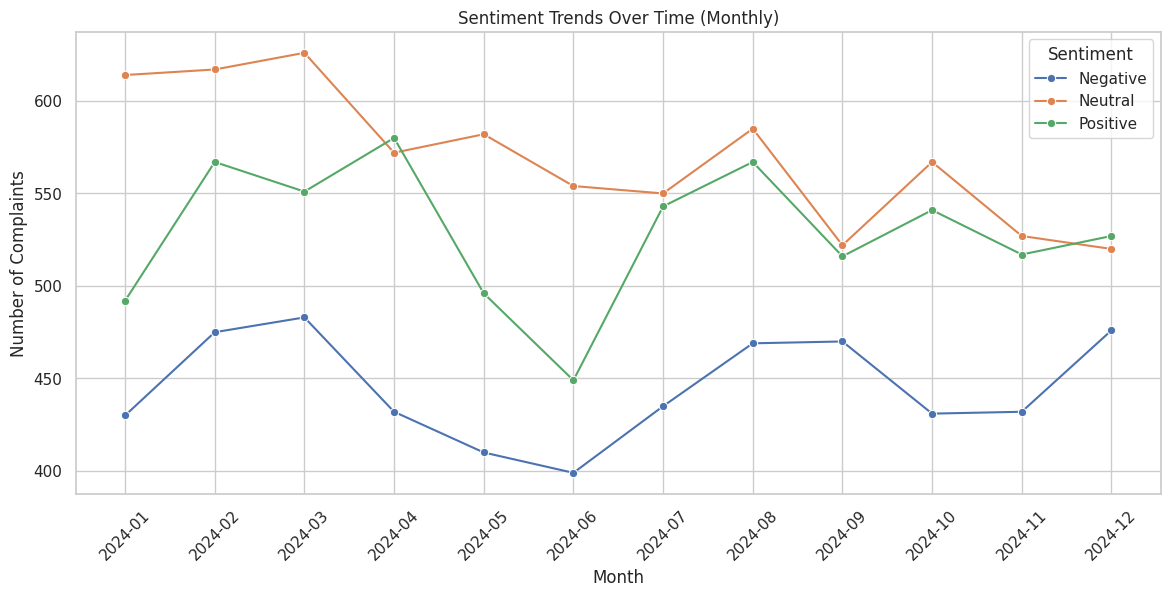

In [37]:
# Group by Year-Month
df['YearMonth'] = df['Date received'].dt.to_period('M').astype(str)

monthly_sentiment = df.groupby(['YearMonth','VADER_Label']).size().reset_index(name='Count')

plt.figure(figsize=(14,6))
sns.lineplot(data=monthly_sentiment, x='YearMonth', y='Count', hue='VADER_Label', marker='o')
plt.xticks(rotation=45)
plt.title('Sentiment Trends Over Time (Monthly)')
plt.xlabel('Month')
plt.ylabel('Number of Complaints')
plt.legend(title='Sentiment')
plt.show()


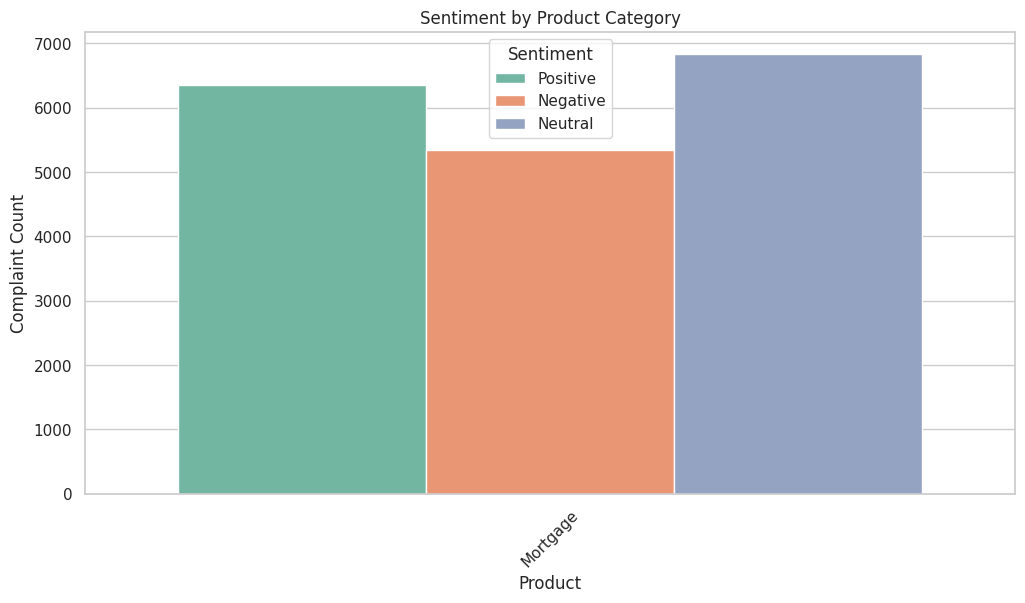

In [38]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='Product', hue='VADER_Label', order=df['Product'].value_counts().index, palette='Set2')
plt.xticks(rotation=45)
plt.title('Sentiment by Product Category')
plt.xlabel('Product')
plt.ylabel('Complaint Count')
plt.legend(title='Sentiment')
plt.show()
